In [56]:
import pandas as pd
import numpy as np
import pickle
import json
import nltk
import re 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer
from nltk.tokenize import word_tokenize
from nltk import NaiveBayesClassifier
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from nltk.stem import RSLPStemmer
from string import punctuation
from sklearn import metrics
from random import shuffle


#### Functions to prepare dataset ####

In [57]:
# cleaning, stemming, tagging, removing stopwords
def clean_up(s):
    words = re.findall('[^\d\W]+', str(s))#, ' '.join(s))
    #words = words.split()
    words = [w.lower() for w in words if not w.startswith('http://') and len(w)>2]
    return ' '.join(words)

def remove_stopwords(l):
    stop_words = stopwords.words('portuguese')
    stop_words.append('ii')
    stop_words.append('iii')
    stop_words.append('iv')
    stop_words.append('º')
    stop_words.append('ª')
    stop_words.append('nº')
    return [word for word in l if word not in stop_words]

# here we try stem and pos_tag to check, the lemmatization does not work well in portuguese
## the pos tag was trainned below as 'tagger' with a specific algorithm for portuguese language
def tag_stem(l):
    tagged = tagger.tag(l)
    words, tags = zip(*tagged)
    stem = [RSLPStemmer().stem(word) for word in words]
    return list(zip(stem,tags))

# applying all
def set_up(x):
    return x.apply(clean_up).apply(word_tokenize).apply(remove_stopwords).apply(tag_stem)

# this funcion will clean the english tags to be portuguese friendly
def convert_to_universal_tag(t, reverse=False):
    tagdict = {
        'n': "NOUN",
        'num': "NUM",
        'v-fin': "VERB",
        'v-inf': "VERB",
        'v-ger': "VERB",
        'v-pcp': "VERB",
        'pron-det': "PRON",
        'pron-indp': "PRON",
        'pron-pers': "PRON",
        'art': "DET",
        'adv': "ADV",
        'conj-s': "CONJ",
        'conj-c': "CONJ",
        'conj-p': "CONJ",
        'adj': "ADJ",
        'ec': "PRT",
        'pp': "ADP",
        'prp': "ADP",
        'prop': "NOUN",
        'pro-ks-rel': "PRON",
        'proadj': "PRON",
        'prep': "ADP",
        'nprop': "NOUN",
        'vaux': "VERB",
        'propess': "PRON",
        'v': "VERB",
        'vp': "VERB",
        'in': "X",
        'prp-': "ADP",
        'adv-ks': "ADV",
        'dad': "NUM",
        'prosub': "PRON",
        'tel': "NUM",
        'ap': "NUM",
        'est': "NOUN",
        'cur': "X",
        'pcp': "VERB",
        'pro-ks': "PRON",
        'hor': "NUM",
        'pden': "ADV",
        'dat': "NUM",
        'kc': "ADP",
        'ks': "ADP",
        'adv-ks-rel': "ADV",
        'npro': "NOUN",
    }
    if t in ["N|AP","N|DAD","N|DAT","N|HOR","N|TEL"]:
        t = "NUM"
    if reverse:
        if "|" in t: t = t.split("|")[0]
    else:
        if "+" in t: t = t.split("+")[1]
        if "|" in t: t = t.split("|")[1]
        if "#" in t: t = t.split("#")[0]
    t = t.lower()
    return tagdict.get(t, "." if all(tt in punctuation for tt in t) else t)

# bag of words
def bow(x, n=5000):
    allwords = [w for words in x for w in words if len(w) > 1]
    bag = {k:allwords.count(k) for k in allwords}
    sorted_bag = sorted(bag.items(), key=lambda kv: kv[1], reverse=True)
    sb = {k:v for k,v in sorted_bag[:n]}
    return pd.DataFrame(sb, index=['values'])

# check if words are in text
def find_features(document):
    word = set(document)
    return {w:(w in word) for w in words.columns}

# multiply two lists
def mult(a,b, c=[]):
    for i in range(len(a)):
        c.append(a[i]*b[i])
    return c

# separating words from tags
def words(l):
    words, tags = zip(*l)
    return [word for word in words]

def tags(l):
    words, tags = zip(*l)
    return [tag.lower() for tag in tags]

# adding weights to each
def weight(l, d):
    res = []
    for i in l:
        try:
            res.append(d[i])
        except:
            res.append(0)
    return res

# assign weights for vectors
def assign_weights(a, b, c=[]):
    for i in range(len(a)):
        return [(a[i] * np.array(b[i])).tolist()]

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-57-9e0326d060fe>:3: DeprecationWarning: invalid escape sequence \d
  words = re.findall('[^\d\W]+', str(s))#, ' '.join(s))


In [58]:
# to bypass an issue with the 64bit python version, i had to add the following function
def hash32(value):
    return hash(value) & 0xffffffff

# to train the model i will apply this function
# the funciont will take the word Series and the Tag series to train the model doc by doc
def doc2vec_trainer(ws, ts, fname, c=0):
    model_doc = Doc2Vec([TaggedDocument(ws[0], ts[0])], size = 100, window = 1, min_count = 1,
                        workers=3, hashfxn=hash32, alpha=0.001, min_alpha=0.00025)
    model_doc.save(fname)
    for i in range(1, len(ws)):
        model_doc.train([TaggedDocument(ws[i], ts[i])], total_examples=model_doc.corpus_count,
                         epochs=model_doc.iter)
        model_doc.alpha -= 0.0002 # adjusting the learning rate
        model_doc.min_alpha = model_doc.alpha
        model_doc.save(fname)
        c+=1
        print('Learned {} from {}!'.format(c, len(ws)))
    print('Success! Model updated.')
    return model_doc

#### Training model for Portuguese POS tagging
For lemmatization to work well in portuguese language and to avoid ambiguity, we need to train the model for recognizing and tagging by the Part-of-Speech method.

In [62]:
nltk.download('floresta')
nltk.download('mac_morpho')
# nltk.corpus.mac_morpho.tagged_sents is incorrect, converting tagged_paras to tagged_sents
dataset1 = list(nltk.corpus.floresta.tagged_sents())
dataset2 = [[w[0] for w in sent] for sent in nltk.corpus.mac_morpho.tagged_paras()]

traindata = [[(w, convert_to_universal_tag(t)) for (w, t) in sent] for sent in dataset1]
traindata2 = traindata + [[(w, convert_to_universal_tag(t, reverse=True)) for (w, t) in sent]
                          for sent in dataset2]

shuffle(traindata)
shuffle(traindata2)

regex_patterns = [(r"^[nN][ao]s?$", "ADP"), (r"^[dD][ao]s?$", "ADP"), (r"^[pP]el[ao]s?$", "ADP"),
                  (r"^[nN]est[ae]s?$", "ADP"), (r"^[nN]um$", "ADP"), (r"^[nN]ess[ae]s?$", "ADP"),
                  (r"^[nN]aquel[ae]s?$", "ADP"), (r"^\xe0$", "ADP")]


[nltk_data] Downloading package floresta to
[nltk_data]     C:\Users\Evelien\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\floresta.zip.
[nltk_data] Downloading package mac_morpho to
[nltk_data]     C:\Users\Evelien\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\mac_morpho.zip.


In [63]:
# training model and getting tagger ready
tagger = nltk.BigramTagger(
            traindata, backoff=nltk.RegexpTagger(
                regex_patterns, backoff=nltk.UnigramTagger(
                    traindata2, backoff=nltk.AffixTagger(
                        traindata2, backoff=nltk.DefaultTagger('NOUN')))))

templates = nltk.brill.fntbl37()
tagger = nltk.BrillTaggerTrainer(tagger, templates)
tagger = tagger.train(traindata, max_rules=100)

# saving model
f = open('tagger.pickle', 'wb')
pickle.dump(tagger, f)
f.close()

In [64]:
#nltk.accuracy(tagger, traindata)

#### Importing data and getting text ready

In [65]:
# importing dataset and getting only unique values
df = pd.read_csv('decisions.csv', index_col='Unnamed: 0')
uniq = pd.DataFrame()
uniq['main'] = df['Main Judgement'].unique()
uniq['main'] = uniq['main'].dropna()
uniq['len'] = uniq['main'].apply(str).apply(len)
uniq = uniq[uniq['len'] > 50]
uniq

,main,len
0,I. De acordo com o despacho proferido nos...,2653
1,I. Defere-se a presente reclamação para a ...,792
2,I. O estabelecimento hospital que contribuiu ...,1240
3,"I - A Formação admitiu a revista excepcional, ...",1807
4,"I Resulta do artigo 2109º, nº1 do CCivil que o...",1869
...,...,...
9845,I - A matéria de facto só pode ser alterada pe...,1229
9846,"I - Em sede de saneador-sentença, o juiz deve,...",1693
9847,I. Para decidir se é ou não de atribuir relev...,1789
9848,I. O STJ pode censurar o mau uso que o Tribuna...,2826


In [9]:
# loading pos_tags model for portuguese language
f = open('tagger.pickle', 'rb')
tagger = pickle.load(f)
f.close()
# getting tokenized and applying predetermined functions
tokens_save = set_up(uniq['main'])
tokens_save.head()

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Evelien/nltk_data'
    - 'C:\\Users\\Evelien\\Anaconda3\\nltk_data'
    - 'C:\\Users\\Evelien\\Anaconda3\\share\\nltk_data'
    - 'C:\\Users\\Evelien\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Evelien\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [73]:
with open("tokens.json", "w") as f:
    json.dump(tokens_save.to_dict(), f)

In [10]:
with open('tokens.json') as json_data:
    data = json.load(json_data)

#### Features Dataframe
Vectorizing all the words and tags, assigning weights to each and composing a dataframe with these features for further analysis and clustering

In [11]:
tokens = pd.DataFrame()
tokens['main'] = data.values()
tokens.head()

,main
0,"[[acord, NOUN], [despach, NOUN], [profer, VERB..."
1,"[[def, VERB], [pres, ADJ], [reclam, NOUN], [co..."
2,"[[estabelec, NOUN], [hospit, NOUN], [contribu,..."
3,"[[form, NOUN], [admit, VERB], [revist, NOUN], ..."
4,"[[result, VERB], [artig, NOUN], [ccivil, NOUN]..."


In [12]:
features = pd.DataFrame()
features['main'] = tokens['main']
features['words'] = tokens['main'].apply(words)
features['tags'] = tokens['main'].apply(tags)

In [8]:
# vectorizing
n=50
model_w = Word2Vec(features['words'], min_count=1, size=n, workers=3, window=5, sg=1)
model_t = Word2Vec(features['tags'], min_count=1, size=n, workers=3, window=5, sg=1)
#model_w.most_similar()

In [70]:
# vectorizing the text with Tf idf
vectorizer_w = TfidfVectorizer()
vectorizer_w.fit_transform(features['words'].apply(' '.join))
vec_dic_w = dict(zip(vectorizer_w.get_feature_names(), vectorizer_w.idf_))

In [71]:
vectorizer_t = TfidfVectorizer()
vectorizer_t.fit_transform(features['tags'].apply(' '.join))
vec_dic_t = dict(zip(vectorizer_t.get_feature_names(), vectorizer_t.idf_))

In [72]:
features['td_word'] = features['words'].apply(lambda x: [vec_dic_w[w] for w in x])

In [74]:
features['td_tags'] = features['tags'].apply(lambda x: [
                      vec_dic_t[t] if t in vec_dic_t else 1 for t in x])

In [75]:
features['td_wxt'] = features.apply(lambda x: mult(x['td_word'], x['td_tags']), axis=1)

In [ ]:
features['weighted_tdidf'] = features.apply(lambda x: )
#mult(features['td_word'][0], features['td_tags'][0])
#mult([1,2,3], [1,2,3])

In [76]:
def td_idf(l1, l2, d):
    for k in d:
        if k in l1:
            x = l2
        else:
            0

(223, 223)

In [ ]:
features['weight_tdidf'] = features['words'].apply(
                    lambda x: [v if k in x else 0 for k,v in vec_dic_w.items()])

In [ ]:
# adding tf idf as feature
features['tdidf'] = features['words'].apply(
                    lambda x: [v if k in x else 0 for k,v in vec_dic_w.items()])

In [ ]:
features['tdidf_t'] = features['tags'].apply(
                      lambda x: [vec_dic_t[] v if k in x else 0 for k,v in vec_dic_w.items()])

In [37]:
def test(l)
    

460.0786111719869

In [ ]:
features['td_tag_word'] = features['words']*features

In [12]:
# adding tf idf as weights
features['weight_w'] = features['words'].apply(lambda x: weight(x, vec_dic_w))
features['weight_t'] = features['tags'].apply(lambda x: weight(x, vec_dic_t))

In [13]:
# adding vectors
features['vectors_w'] = features['words'].apply(lambda x: [model_w[w] for w in x])

C:\Users\felip\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [14]:
features['vectors_w'] = features['words'].apply(
                        lambda x: [model_w[w] if w in x else np.zeros(n) for w in vec_dic_w])
# it might not be worth to vectorize the tags, maybe making them dummies is a better approuch 
# features['vectors_t'] = features['tags'].apply(lambda x: [model_t[w] for w in x])

C:\Users\felip\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


MemoryError: 

In [14]:
# getting dummies
tags = pd.Series([i for ii in features['tags'] for i in ii]).unique()

for c in tags:
    features[c] = features['tags'].apply(lambda x: [1 if t == c else 0 for t in x])

In [15]:
# applying weights
## confirm if we should use dot or normal multiplication
#assign_weights = lambda x: [(x['weight_w'][i] * np.array(x['vectors_w']))
#                             for i in range(len(x['weight_w']))]

features['word_v'] = features[['weight_w', 'vectors_w']].apply(lambda x: np.dot(np.array(x['weight_w']), np.array(x['vectors_w'])), axis=1)
features['word_v']

0       [204.5034159558449, -87.62844604194666, 208.42...
1       [36.22991062970964, -17.777194011136668, 33.04...
2       [112.7604887675096, -56.5621460817556, 91.7640...
3       [77.2860801302986, -70.24553094875054, 109.518...
4       [199.03621543645858, -61.46741759711002, 162.6...
                              ...                        
9843    [118.80132786379683, -62.090736347056136, 97.0...
9844    [80.3518284392613, -67.16384545796089, 132.145...
9845    [198.38254171590046, -116.2080826108005, 84.54...
9846    [181.25976429522734, -91.30012141223202, 179.1...
9847    [62.41769913203094, -27.29416976415753, 31.355...
Name: word_v, Length: 9848, dtype: object

#### Polarity Checking for Positive/Negative rullings

In [21]:
sum(uniq['main'].apply(lambda x: 1 if len(re.findall('improced.+', x)) > 0 else 0) )

324

In [18]:
# to try separeting the positive and negative rullings i will do an average of words,
# usually related to negative outcome:
lengths = features['words'].apply(len)
polar = np.diag(uniq['main'].apply(lambda x: (len(re.findall('nem', x))+len(re.findall('não', x))+\
                                   len(re.findall('inexiste', x))+\
                                   len(re.findall('negado', x))+\
                                   len(re.findall('deveria', x))+len(re.findall('falta', x))+\
                                   len(re.findall('demonstre', x))+\
                                   len(re.findall('improced.+', x))*1.5+\
                                   len(re.findall('insucesso', x)))/lengths))

In [19]:
# 1 for positive, 0 for negative 
features['polarity'] = [1 if p <= 0.03 else 0 for p in polar]

In [ ]:
np.array(features['vectors_w'][0][1]).shape

In [ ]:
# final dataframe
features.head()

In [ ]:
# features.to_csv('features.csv')

#### Supervised Learning 

In [25]:
X = np.array(features['words'].apply(' '.join))
y = np.array(features['polarity'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
X_train

2299    caus discut respons advog insucess obt noutr a...
6297    requisit juíz reprov aquis alud norm estabelec...
578     admiss recurs revist term art cir recorr além ...
7279    administr part comum edifíci pertenc compropri...
3630    indic númer alvar dat emiss câm municip escrit...
                              ...                        
9261    princípi geral proib anatoc estabelec art civ ...
2419    decis judic decl nulidad act administr plur ca...
768     cláusul penal compensatór cons estipul antecip...
3366    compet internac tribun portugues dev ser afer ...
5815    sobr decis cont sentenç acórd sobr fundament f...
Name: words, Length: 7878, dtype: object

In [24]:
# SVC
pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                        ('clf', OneVsRestClassifier(
                            LinearSVC(), n_jobs=1))])

parameters = {"clf__estimator__C": [0.01, 0.1, 1],
        "clf__estimator__class_weight": ['balanced', None]}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=3, n_jobs=3, verbose=10)
grid_search_tune.fit(X_train,y_train)
best_svc = grid_search_tune.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   16.5s


AttributeError: lower not found

In [24]:
y_pred_svc = best_svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))
cross_val_score(best_svc, X, y, cv=5)

              precision    recall  f1-score   support

           0       0.60      0.64      0.62       938
           1       0.65      0.61      0.63      1032

    accuracy                           0.63      1970
   macro avg       0.63      0.63      0.63      1970
weighted avg       0.63      0.63      0.63      1970



In [ ]:
#RFC
pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                        ('clf', OneVsRestClassifier(
                            RandomForestClassifier(), n_jobs=1))])
## best param = 401
parameters = {"clf__estimator__n_estimators": list(range(1,1000,100))}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=3, n_jobs=3, verbose=10)
grid_search_tune.fit(X_train,y_train)
best_svc = grid_search_tune.best_estimator_

y_pred_svc = best_svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))

cross_val_score(best_svc, X, y, cv=5)

In [25]:
# KNN
parameters = {'n_neighbors': np.arange(1,10), 'weights': ['uniform', 'distance']} 
knn = KNeighborsClassifier()
grid_search_tune = GridSearchCV(knn, parameters, cv=5)
grid_search_tune.fit(X_train,y_train)
best_knn = grid_search_tune.best_estimator_

In [26]:
y_pred_knn = best_knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))


              precision    recall  f1-score   support

           0       0.51      0.39      0.45       938
           1       0.54      0.66      0.60      1032

    accuracy                           0.53      1970
   macro avg       0.53      0.53      0.52      1970
weighted avg       0.53      0.53      0.52      1970



#### Training the models with Word2Vec
Here we will use BernoulliNB for incremental learning

In [ ]:
from sklearn.naive_bayes import BernoulliNB
# resizing data
X = np.array(X.tolist())
y = np.array(y.tolist())
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

In [ ]:
from sklearn.naive_bayes import BernoulliNB
# resizing data
X = np.array(X.tolist())
y = np.array(y.tolist())
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

In [ ]:
# averaging word vectors per document, considering td idf as weight
def averager(l):
    return
averager([[1,2],[2,3]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [ ]:
model_b = BernoulliNB()
model_w2v = features.apply(lambda x: w2v_incremental(
            x['vectors_w'][:20], x['polarity'][:20], model_b, 'w2v_inc.model'), axis=1)

In [ ]:
def w2v_incremental(X, y, model, fname):
    model.load(fname)
    
    model_w2v = grid.fit(X_train, y_train)
    pickle.dump(model, open(fname, 'wb'))
    return model_w2v

In [ ]:
y_pred_svc = best_svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))

#### Clustering with Unsupervised Learning

In [27]:
X = np.array(features['tdidf'].tolist())

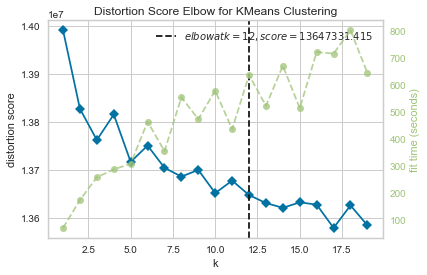

In [28]:
visualizer = KElbowVisualizer(KMeans(), k=(1,20))
visualizer.fit(X)
visualizer.poof()

In [29]:
modelk_end = KMeans(n_clusters=3)
modelk_end.fit(np.array(X))
features['kpos_neg'] = modelk_end.labels_

In [ ]:
modelk_topics = KMeans(n_clusters=visualizer.elbow_value_)
modelk_topics.fit(np.array(X))
features['ktopics'] = modelk_topics.labels_

In [ ]:
# bag of words
bow = bow(features['words'])

#### Clustering Documents:
##### word2vec & AffinityPropagation

In [20]:
# train word2vec model
doc2vec_trainer(features['words'], features['words'], "d2v.model")
model_doc = Doc2Vec.load("d2v.model")

In [ ]:
model_doc.docvecs[21]

In [ ]:
# vectorize documents
X = np.array([model_doc.infer_vector(x) for x in features['words']])
X

In [ ]:
# train clustering model
clustering = AffinityPropagation().fit(X)
clustering

In [ ]:
cluster_centers_indices = clustering.cluster_centers_indices_ 
labels = clustering.labels_ 
  
n_clusters_ = len(cluster_centers_indices) 

labels, n_clusters_

## 

In [ ]:
#getting bag of word ready for bayes
#documents = list(zip(corpus, np.where(ds['target'] == 4, True, False)))
#featuresets = [(find_features(rev), category) for (rev, category) in documents]
#train_set, test_set = featuresets[200:], featuresets[:200]
#classifier = nltk.NaiveBayesClassifier.train(train_set)
#nltk.classify.accuracy(classifier, test_set)

In [ ]:
## remember to take off 'não' to check
print(stopwords.words('portuguese'))

In [78]:
vec_dic_w

0       [acord, despach, profer, aut, pres, cas, decis...
1       [def, pres, reclam, confer, admit, recurs, cir...
2       [estabelec, hospit, contribu, trat, assist, ví...
3       [form, admit, revist, excepc, fundament, art, ...
4       [result, artig, ccivil, val, bem, do, mesm, da...
                              ...                        
9843    [matér, fact, pod, ser, alter, stj, verif, alg...
9844    [sed, sane, sentenç, juiz, dev, term, art, cpc...
9845    [decid, atribu, relev, caus, exclus, culp, ale...
9846    [stj, pod, censur, mau, uso, tribun, relaç, ev...
9847    [constitu, associ, particip, situ, alguém, exe...
Name: words, Length: 9848, dtype: object

In [ ]:
bow = pd.DataFrame(vec_dic_w, index=features['words'])

In [96]:

def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

model = train_doc2vec_model(train_tagged)

y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)

In [ ]:
X = np.array([model_doc.infer_vector(x) for x in features['words']])
y = np.array(features['polarity'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                        ('clf', OneVsRestClassifier(
                            LinearSVC(), n_jobs=1))])

parameters = {"clf__estimator__C": [0.01, 0.1, 1],
        "clf__estimator__class_weight": ['balanced', None]}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=3, n_jobs=3, verbose=10)

In [33]:
grid_search_tune.fit(X_train,y_train)
best_svc = grid_search_tune.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    3.5s


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

#### LDA

In [ ]:
# bag of words
lst_words = [i for ii in df['words'].str.split() for i in ii if len(i) > 1]
corpora = ' '.join(df['words'])
bow = {k: corpora.count(k) for k in lst_words}
bow_corpus = [bow.doc2bow(word) for word in df['words'].str.split()]

In [ ]:
#LDA
parameters = {"lda__estimator__n_components": list(range(5,15)),
              "lda__estimator__learning_decay": [0.5, 0.7, 0.9]}

grid_search_tune = GridSearchCV(LdaMulticore(), parameters, cv=3, n_jobs=3, verbose=10)
grid_search_tune.fit(bow_corpus)
best_log = grid_search_tune.best_estimator_

In [50]:
import xgboost

cv = CountVectorizer()
X = cv.fit_transform(features['words'].apply(' '.join))

#y = features['polarity']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1

In [43]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA().fit_transform(X)

In [55]:
word_list = cv.get_feature_names()
count_list = X.toarray().sum(axis=0)   
bow_dic = dict(zip(word_list,count_list))
bow_dic

remove_words = []

for docs in features['words'].to_list():
    

{'__________': 1,
 '________________': 1,
 '_________________________': 1,
 '______________________________': 1,
 'aafdl': 3,
 'aarr': 1,
 'ab': 1,
 'abaix': 24,
 'abal': 46,
 'abaliz': 2,
 'abalro': 6,
 'abandon': 122,
 'abandonám': 1,
 'abarc': 106,
 'abarqu': 3,
 'abarrac': 1,
 'abastec': 19,
 'abat': 28,
 'abaç': 3,
 'abdic': 26,
 'abdom': 4,
 'abdómen': 3,
 'abe': 1,
 'abeber': 1,
 'abel': 3,
 'aberr': 4,
 'aberrati': 2,
 'abert': 312,
 'abl': 4,
 'abla': 7,
 'abol': 15,
 'aboli': 2,
 'abomin': 2,
 'abon': 11,
 'abonatóri': 1,
 'abor': 2,
 'abord': 60,
 'aborrec': 5,
 'abort': 9,
 'abr': 74,
 'abrag': 1,
 'abrand': 7,
 'abrang': 742,
 'abranj': 7,
 'abraç': 1,
 'abrevi': 9,
 'abreviat': 2,
 'abrig': 474,
 'abril': 100,
 'abrir': 1,
 'abrupt': 11,
 'absolu': 1,
 'absolut': 583,
 'absolutór': 18,
 'absolutóri': 3,
 'absolv': 254,
 'absort': 1,
 'absorv': 13,
 'absorç': 4,
 'abst': 37,
 'absten': 1,
 'abstenh': 2,
 'abstenç': 39,
 'abstev': 5,
 'abstiv': 2,
 'abstr': 13,
 'abstra': 2

In [54]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, features['words'].apply(' '.join), bow_dic)

ValueError: not enough values to unpack (expected 2, got 1)

In [44]:
lda.show_topics

AttributeError: 'numpy.ndarray' object has no attribute 'show_topics'

In [41]:
from gensim.models import LdaMulticore

In [42]:
lda_model = LdaMulticore(X)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().